### Import Packages And Build The Optimization Framework

c:\Users\AMEEN\anaconda3\envs\BSM2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\AMEEN\anaconda3\envs\BSM2\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


17:18:58.353 INFO     Using device cpu
Using device cpu
17:18:58.769 INFO     Stabilizing the model


c:\Users\AMEEN\anaconda3\envs\BSM2\lib\site-packages\skorch\net.py:2626: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f_name, map_location=map_location)
c

Stabilizing the model
17:19:21.716 INFO     Stabilized after 3699 iterations

Stabilized after 3699 iterations

17:19:21.736 INFO     Get data for first steps
Get data for first steps


100%|██████████| 144/144 [00:01<00:00, 105.14it/s]

17:19:23.153 INFO     Get data for optimization steps


Get data for optimization steps
17:19:23.955 INFO     Optimizing kla_4
Optimizing kla_4
Number of variables: 205344
Number of constraints: 186672
Objective function: 0.0

Detailed Optimization Results:
Total Objective Value: -113821.44
Weighted operational Cost (1.00*-113822.62): -113822.62
Weighted Violation Cost (1.00*1.18): 1.18

KLA Statistics:
Average KLA: 42.25
Min KLA: 0.00
Max KLA: 240.00
Optimization successful
Objective Value: -113821.44009855749
Violation Cost: 1.1836608831224666
Heat Cost: 372000.07544309815
Biogas Income: 46.720868847684564
17:23:39.528 INFO     run simulation with optimized kla_4
run simulation with optimized kla_4
Shape of gurobi_results: (1777, 8)
Shape of results: (1777, 8)
Shape of bsm2.simtime: (1921,)
17:23:41.503 INFO     Plotting results
Plotting results


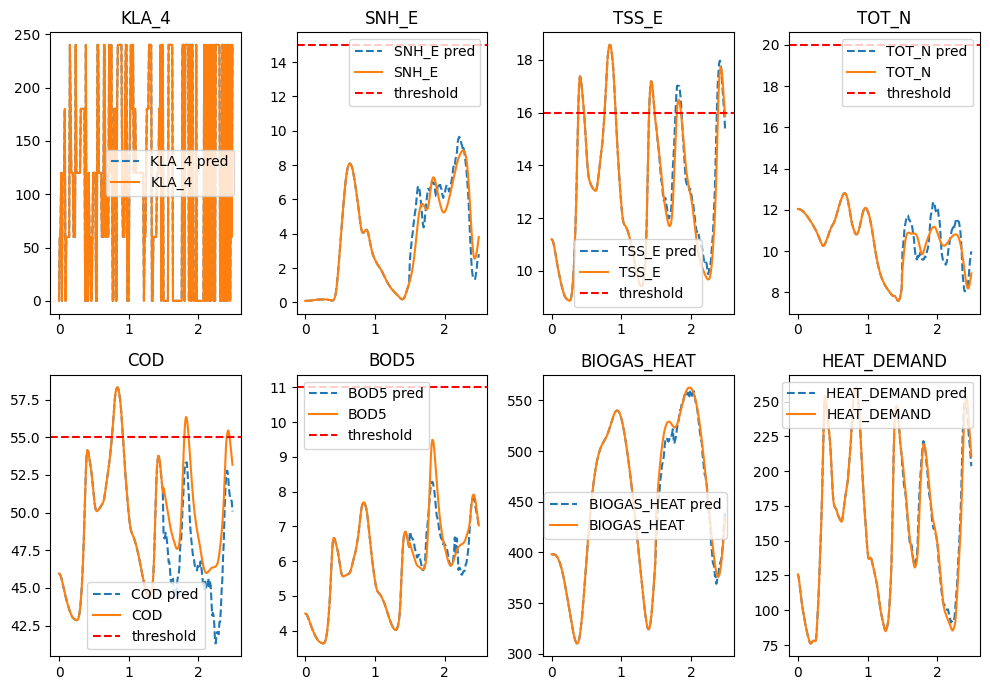

In [144]:
import sys
import os
import ast
import pickle
import pickle as pkl
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import torch
from gurobi_ml import add_predictor_constr, register_predictor_constr
from gurobi_ml.sklearn.preprocessing import add_standard_scaler_constr
from sklearn.pipeline import make_pipeline
from skorch import NeuralNetRegressor
from skorch.dataset import ValidSplit
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from gurobi_ml.torch.sequential import add_sequential_constr
import bsm2_python.bsm2.init.plantperformanceinit_bsm2 as pp_init
from bsm2_python.bsm2.init.aerationcontrolinit import KLA3GAIN, KLA5GAIN
from bsm2_python.bsm2.init.reginit_bsm2 import T_OP
from bsm2_python.bsm2.plantperformance import PlantPerformance
import bsm2_python.bsm2.init.asm1init_bsm2 as asm1init
from bsm2_python.bsm2_ol import BSM2OL
from bsm2_python.gases.gases import GasMix
from bsm2_python.log import logger
from nn_functions import add_skorch_constr, choose_kla_4, load_scaler_and_pca, transform_influent
import bsm2_python.bsm2.init.adm1init_bsm2 as adm1init

SI, SS, XI, XS, XBH, XBA, XP, SO, SNO, SNH, SND, XND, SALK, TSS, Q, TEMP, SD1, SD2, SD3, XD4, XD5 = np.arange(21)

scaler_y_in, pca_y_in = load_scaler_and_pca('scaler_pca_5_4exe.pkl')
bsm2 = BSM2OL(endtime=20)
pp = PlantPerformance(pp_init.PP_PAR)

# 36 hours are considered
last_steps = 144  
select = np.array([0,60,120,180,240])
kla_4 = 0
influent = bsm2.y_in[0, :]
influent = transform_influent(influent.reshape(1, -1), scaler_y_in, pca_y_in).flatten()
biogas_heat = 0
heat_demand = 0

num_features = len((kla_4, *influent))
effluent = np.zeros((5,))
num_targets = len((*effluent, biogas_heat, heat_demand))
num_cols = num_features * last_steps + num_targets
features = np.zeros((bsm2.simtime.size - last_steps, num_features * last_steps))
results = np.zeros((bsm2.simtime.size - last_steps, num_targets + 1))
gurobi_results = np.zeros_like(results)

# Thresholds
SNH_E_threshold = 15
TSS_E_threshold = 16
TOT_N_threshold = 20
COD_threshold = 55
BOD5_threshold = 11



device = 'cuda' if torch.cuda.is_available() else 'cpu'
logger.info(f'Using device {device}')
# Load the model
nn_regression = NeuralNetRegressor(
    nn.Sequential(
        nn.Linear(num_features * last_steps, 128), 
        nn.ReLU(), 
        nn.Linear(128, 64), 
        nn.ReLU(), 
        nn.Linear(64, num_targets)
    ),
    max_epochs=3000,
    lr=0.001,
    iterator_train__shuffle=True,
    device=device,
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    batch_size=262144,
    train_split=ValidSplit(0.2),
    warm_start=True,
)
nn_regression.initialize()
nn_regression.load_params(
    f_params=r'C:\Users\AMEEN\bsm-2-python-lin-opt\Updated Progress files\nn_regression_model_latest_4exe_20000.pth')


with open(r'C:\Users\AMEEN\bsm-2-python-lin-opt\Updated Progress files\Scaler\scaler_latest_4exe_20000.pkl','rb') as f:
    std_scaler = pickle.load(f)

pipeline = make_pipeline(std_scaler, nn_regression)

register_predictor_constr(NeuralNetRegressor, add_skorch_constr)

def optimize_kla_4(last_inputs_flat, optimization_steps, aeration_energies, mixing_energies, pumping_energies, methane_productions):
    logger.info('Optimizing kla_4')
    m = gp.Model()
    m.setParam('OutputFlag', 0)
    #m.setParam('TimeLimit', 3600) 
    # toerlance  
    m.setParam('MIPGap', 0.1)     
    m.setParam('Threads', 4) 

    total_steps = last_steps + optimization_steps
    optimization_start_step = last_steps

    # Continuous relaxation for kla_4
    kla_4_int_helper = m.addMVar(total_steps, lb=0, ub=4, vtype=gp.GRB.INTEGER, name='kla_4_int_helper')
    kla_4_var = m.addMVar(total_steps, lb=0, ub=240, vtype=gp.GRB.CONTINUOUS, name='kla_4')


    # helper for kla, can only take discrete values 0, 60, 120,180,240
    m.addConstr(kla_4_var == kla_4_int_helper * 60)
    # Define input variables
    inputs_var = m.addMVar(last_inputs_flat.shape, 
                           lb=np.min(last_inputs_flat), 
                           ub=np.max(last_inputs_flat), 
                           name='mod_features')

    # Constraints for previous steps
    for i in range(0, optimization_start_step * num_features):
        m.addConstr(inputs_var[i] == last_inputs_flat[i])

    # Constraints for optimization steps using continuous kla_4
    for i in range(optimization_start_step * num_features, total_steps * num_features):
        if i % num_features == 0:
            m.addConstr(inputs_var[i] == kla_4_var[i // num_features])
        else:
            m.addConstr(inputs_var[i] == last_inputs_flat[i])

    # scaler constraints for all optimization steps
    for i in range(optimization_steps):
        add_standard_scaler_constr(
            m, 
            std_scaler, 
            inputs_var[i*num_features:(i+last_steps)*num_features])

    # predictors for each optimization step
    pred_targets_var = m.addMVar(num_targets * optimization_steps, name='pred_targets')

    # predictor constraints for all optimization steps, first step also uses influent data from the previous 143 (last_steps-1) steps
    for i in range(optimization_steps):
        add_predictor_constr(
            m, 
            pipeline, 
            inputs_var[(i+1)*num_features:((i+1)+last_steps)*num_features], 
            pred_targets_var[i*num_targets:(i+1)*num_targets])

    # add helpers for the violation costs, variables show how far the value is above a set threshold
    snh_violation = m.addMVar(optimization_steps, lb=0, name='snh_violation')
    tss_violation = m.addMVar(optimization_steps, lb=0, name='tss_violation')
    tot_n_violation = m.addMVar(optimization_steps, lb=0, name='tot_n_violation')
    cod_violation = m.addMVar(optimization_steps, lb=0, name='cod_violation')
    bod5_violation = m.addMVar(optimization_steps, lb=0, name='bod5_violation')

    # add constraints for the violation amounts, value_x - violation_x <= threshold (value = threshold + violation)
    for i in range(0, optimization_steps):
        m.addConstr(pred_targets_var[i*num_targets] - snh_violation[i] <= SNH_E_threshold)
        m.addConstr(pred_targets_var[i*num_targets+1] - tss_violation[i] <= TSS_E_threshold)
        m.addConstr(pred_targets_var[i*num_targets+2] - tot_n_violation[i] <= TOT_N_threshold)
        m.addConstr(pred_targets_var[i*num_targets+3] - cod_violation[i] <= COD_threshold)
        m.addConstr(pred_targets_var[i*num_targets+4] - bod5_violation[i] <= BOD5_threshold)

    # set the costs for the violations, should be scaled with the thresholds, so all costs are in the same range
    violation_multiplier = 1
    snh_cost = violation_multiplier * 1/SNH_E_threshold
    tss_cost = violation_multiplier * 1/TSS_E_threshold
    tot_n_cost = violation_multiplier * 1/TOT_N_threshold
    cod_cost = violation_multiplier * 1/COD_threshold
    bod5_cost = violation_multiplier * 1/BOD5_threshold

    # calculate the total violation cost (cost factor * violation amount)
    violation_cost = (
        snh_cost * snh_violation.sum()
        + tss_cost * tss_violation.sum()
        + tot_n_cost * tot_n_violation.sum()
        + cod_cost * cod_violation.sum()
        + bod5_cost * bod5_violation.sum())
    
    
    #heat_cost = gp.quicksum(pred_targets_var[i * num_targets + 6] * 1 / 1000 for i in range(optimization_steps))
    #biogas_income = gp.quicksum(pred_targets_var[i * num_targets + 5] * 1 / 1000 for i in range(optimization_steps))

    heat_cost = gp.quicksum(pred_targets_var[i * num_targets + 6] * 24 for i in range(optimization_steps))  # kW to kWh/d
    biogas_heat = gp.quicksum(pred_targets_var[i * num_targets + 5] for i in range(optimization_steps))
    tss_prod = gp.quicksum(pred_targets_var[i * num_targets + 1] for i in range(optimization_steps))
    biogas_income = gp.quicksum(pred_targets_var[i * num_targets + 5] * 1 / 1000 for i in range(optimization_steps))


    aeration_cost = gp.quicksum(aeration_energies[i] * 24 for i in range(optimization_steps))
    mixing_cost = gp.quicksum(mixing_energies[i] * 24 for i in range(optimization_steps))
    pumping_cost = gp.quicksum(pumping_energies[i] * 24 for i in range(optimization_steps))
    methane_prod = gp.quicksum(methane_productions[i] for i in range(optimization_steps))

    net_heating_cost = m.addMVar(1, name='net_heating_cost', lb=0)
    
    # Add constraint that net_heating_cost >= he - 7*mp
    m.addConstr(net_heating_cost >= heat_cost - 7 * methane_prod)
    m.addConstr(net_heating_cost >= 0)

    # Calculate total operational cost manually instead of using pp.oci
    operational_cost = (
        #3 * tss_prod +           # TSS cost
        aeration_cost +          # Aeration energy cost
        mixing_cost +            # Mixing energy cost
        #pumping_cost +           # Pumping energy cost
        0 +                      # Carbon addition cost (0 since no carbon addition)
        net_heating_cost -       # Net heating cost
        6 * methane_prod        # Methane production income
    )

    # Set objective combining operational and violation costs
    w1, w2 = 1.0, 1.0
    m.setObjective(w1 * operational_cost + w2 * violation_cost, gp.GRB.MINIMIZE)
    
    # Add minimum KLA constraints to prevent all-zero solutions,  atleat 30 % non-zero kla values 
    #m.addConstr(gp.quicksum(kla_4_int_helper[i] >= 1 for i in range(total_steps)) >= 0.3*total_steps) 

    #w1, w2, w3 = 1.0, 1.0, 1.0

    #m.setObjective(w1 * violation_cost + w2 * heat_cost - w3 * biogas_income, gp.GRB.MINIMIZE)

    
    # Debug
    print(f"Number of variables: {m.NumVars}")
    print(f"Number of constraints: {m.NumConstrs}")
    print(f"Objective function: {m.getObjective()}")

    m.optimize()

    if m.status == gp.GRB.OPTIMAL:
        print("\nDetailed Optimization Results:")
        print(f"Total Objective Value: {m.objVal:.2f}")
        operational_cost_value = operational_cost.getValue().item()
        print(f"Weighted operational Cost ({w1:.2f}*{operational_cost_value:.2f}): {(w1*operational_cost_value):.2f}")
        print(f"Weighted Violation Cost ({w2:.2f}*{violation_cost.getValue():.2f}): {(w2*violation_cost.getValue()):.2f}")
        #print(f"Weighted Biogas Income ({w3:.2f}*{biogas_income.getValue():.2f}): {(w3*biogas_income.getValue()):.2f}")
    
        # Print average KLA value
        kla_values = [kla_4_var[i].X for i in range(total_steps)]
        print(f"\nKLA Statistics:")
        print(f"Average KLA: {np.mean(kla_values):.2f}")
        print(f"Min KLA: {np.min(kla_values):.2f}")
        print(f"Max KLA: {np.max(kla_values):.2f}")
        print("Optimization successful")
        print("Objective Value:", m.objVal)
        print("Violation Cost:", violation_cost.getValue())
        print("Heat Cost:", heat_cost.getValue())
        print("Biogas Income:", biogas_income.getValue())
        kla_results = np.array([kla_4_var[i].X for i in range(last_steps-1, last_steps+optimization_steps-1)])
        snh_results = np.array([pred_targets_var[i*num_targets].X for i in range(0, optimization_steps)])
        tss_results = np.array([pred_targets_var[i*num_targets+1].X for i in range(0, optimization_steps)])
        tot_n_results = np.array([pred_targets_var[i*num_targets+2].X for i in range(0, optimization_steps)])
        cod_results = np.array([pred_targets_var[i*num_targets+3].X for i in range(0, optimization_steps)])
        bod5_results = np.array([pred_targets_var[i*num_targets+4].X for i in range(0, optimization_steps)])
        biogas_heat_results = np.array([pred_targets_var[i*num_targets+5].X for i in range(0, optimization_steps)])
        heat_demand_results = np.array([pred_targets_var[i*num_targets+6].X for i in range(0, optimization_steps)])

    else:
        print(f"Optimization failed. Status: {m.status}")
        m.computeIIS()
        m.write("model.ilp")
        print("IIS written to file 'model.ilp'")
        return None

    return (
        kla_results,
        snh_results,
        tss_results,
        tot_n_results,
        cod_results,
        bod5_results,
        biogas_heat_results,
        heat_demand_results,
    )

def plot_results(start, stop):
    logger.info('Plotting results')
    has_threshold = [False, True, True, True, True, True, False, False]
    variables = ['KLA_4', 'SNH_E', 'TSS_E', 'TOT_N', 'COD', 'BOD5', 'BIOGAS_HEAT', 'HEAT_DEMAND']

    _, ax = plt.subplots(2, 4, figsize=(10, 7))
    for i, plot_var in enumerate(variables):
        ax[i // 4, i % 4].plot(
            bsm2.simtime[start:stop],
            gurobi_results[start:stop, i],
            label=plot_var + ' pred',
            linestyle='--',
        )
        ax[i // 4, i % 4].plot(
            bsm2.simtime[start:stop], results[start:stop, i], label=plot_var
        )
        if has_threshold[i]:
            threshold_var = f"{plot_var}_threshold"
            if threshold_var in globals():
                ax[i // 4, i % 4].axhline(
                    y=globals()[threshold_var], color='r', linestyle='--', label='threshold'
                )
        ax[i // 4, i % 4].legend()
        ax[i // 4, i % 4].set_title(plot_var)
    plt.tight_layout()
    plt.show()

optimization_steps = 96

last_inputs = np.zeros((last_steps + optimization_steps, num_features))
aeration_energies = np.zeros(last_steps + optimization_steps)
mixing_energies = np.zeros(last_steps + optimization_steps)
pumping_energies = np.zeros(last_steps + optimization_steps)
methane_productions = np.zeros(last_steps + optimization_steps)

logger.info('Stabilizing the model')
bsm2.stabilize()

logger.info('Get data for first steps')

for i in tqdm(range(0, last_steps)):
    gurobi_result = np.zeros(8)

    kla_4 = choose_kla_4(select, 1, kla_4)
    #kla_4 = np.random.choice(select)
    influent = bsm2.y_in[np.where(bsm2.data_time <= bsm2.simtime[i])[0][-1], :]
    influent = transform_influent(influent.reshape(1, -1), scaler_y_in, pca_y_in).flatten()
    last_inputs[i] = np.concatenate((np.array([kla_4]), influent))

    # shift last_inputs and add the new input
    klas = np.array([0, 0, KLA3GAIN * kla_4, kla_4, KLA5GAIN * kla_4])
    bsm2.step(i, klas)

    adv_eff = pp.advanced_quantities(bsm2.y_eff, components=('totalN', 'COD', 'BOD5'))
    tot_n, cod, bod5 = adv_eff[0, :]
    effluent = np.array((bsm2.y_eff[SNH], bsm2.y_eff[TSS], tot_n, cod, bod5))
    ch4_prod, h2_prod, co2_prod, q_gas = pp.gas_production(bsm2.yd_out, T_OP, p_atm=1.0130)
    biogas = GasMix(ch4_prod, co2_prod, h2_prod)
    biogas_heat = biogas.h_u * q_gas / 24  # kW
    
    # get the heat demand in kW
    heat_demand = pp.heat_demand_step(bsm2.yd_in, T_OP)  
    # Add aeriation energy in kW
    aeration_energy = pp.aerationenergy_step(
        klas,
        np.array([asm1init.VOL1, asm1init.VOL2, asm1init.VOL3, asm1init.VOL4, asm1init.VOL5]),
        np.array([asm1init.SOSAT1, asm1init.SOSAT2, asm1init.SOSAT3, asm1init.SOSAT4, asm1init.SOSAT5])
    )
    
    # Add mixing energy in kW
    mixing_energy = pp.mixingenergy_step(
        klas,
        np.array([asm1init.VOL1, asm1init.VOL2, asm1init.VOL3, asm1init.VOL4, asm1init.VOL5, adm1init.V_LIQ]),
        pp_init.PP_PAR[16])
    
    # Add pumping energy in kW
    flows = np.array([asm1init.QINTR, asm1init.QR, asm1init.QW, bsm2.yp_uf[Q], bsm2.yt_uf[Q], bsm2.ydw_s[Q]])
    pumping_energy = pp.pumpingenergy_step(flows, pp_init.PP_PAR[10:16])

    # Calculate methane production in kg/d
    ch4_prod, _, _, _ = pp.gas_production(bsm2.yd_out, T_OP, p_atm=1.0130)
    methane_productions[i] = ch4_prod
    aeration_energies[i] = aeration_energy
    mixing_energies[i] = mixing_energy
    pumping_energies[i] = pumping_energy
    
    # save results for comparison
    results[i, :] = np.array((kla_4, *effluent, biogas_heat, *heat_demand))
    gurobi_results[i, :] = np.array((kla_4, *effluent, biogas_heat, *heat_demand))

    

optimization_start_step = last_steps
optimization_end_step = last_steps + optimization_steps

#scale_kla = StandardScaler()
#kla_possible_values = select.reshape(-1, 1)
#scale_kla.fit(kla_possible_values)


logger.info('Get data for optimization steps')
for i in range(optimization_start_step, optimization_end_step):
    #initial_kla = 0
    #kla_4 = scale_kla.transform([[initial_kla]]).flatten()[0]
    kla_4 = -1 
    
    influent = bsm2.y_in[np.where(bsm2.data_time <= bsm2.simtime[i])[0][-1], :]
    influent = transform_influent(influent.reshape(1, -1), scaler_y_in, pca_y_in).flatten()
    last_inputs[i] = np.concatenate((np.array([kla_4]), influent))

    klas = np.array([0, 0, KLA3GAIN * kla_4, kla_4, KLA5GAIN * kla_4])
    bsm2.step(i, klas)

last_inputs_flat = last_inputs.flatten()

# actually run the optimization
gurobi_kla, gurobi_snh, gurobi_tss, gurobi_tot_n, gurobi_cod, gurobi_bod5, gurobi_biogas_heat, gurobi_heat_demand \
    = optimize_kla_4(
    last_inputs_flat, 
    optimization_steps,
    aeration_energies,
    mixing_energies,
    pumping_energies,
    methane_productions)

logger.info('run simulation with optimized kla_4')
for i in range(0, optimization_steps):
    # Apply the KLA control first
    kla_4 = gurobi_kla[i]
    klas = np.array([0, 0, KLA3GAIN * kla_4, kla_4, KLA5GAIN * kla_4])
    bsm2.step(last_steps+i, klas)
    
    # Then store the results
    gurobi_results[last_steps+i, :] = np.array((gurobi_kla[i], 
                                                gurobi_snh[i], 
                                                gurobi_tss[i], 
                                               gurobi_tot_n[i], 
                                               gurobi_cod[i], 
                                               gurobi_bod5[i], 
                                               gurobi_biogas_heat[i], 
                                               gurobi_heat_demand[i]))

    # Store actual simulation results
    adv_eff = pp.advanced_quantities(bsm2.y_eff, components=('totalN', 'COD', 'BOD5'))
    tot_n, cod, bod5 = adv_eff[0, :]
    effluent = np.array((bsm2.y_eff[SNH], bsm2.y_eff[TSS], tot_n, cod, bod5))
    
    ch4_prod, h2_prod, co2_prod, q_gas = pp.gas_production(bsm2.yd_out, T_OP, p_atm=1.0130)
    biogas = GasMix(ch4_prod, co2_prod, h2_prod)
    biogas_heat = biogas.h_u * q_gas / 24  # kW
    heat_demand = pp.heat_demand_step(bsm2.yd_in, T_OP)  # kW
    
    # Add aeriation energy in kW
    aeration_energy = pp.aerationenergy_step(
        klas,
        np.array([asm1init.VOL1, asm1init.VOL2, asm1init.VOL3, asm1init.VOL4, asm1init.VOL5]),
        np.array([asm1init.SOSAT1, asm1init.SOSAT2, asm1init.SOSAT3, asm1init.SOSAT4, asm1init.SOSAT5])
    )
    
    # Add mixing energy in kW
    mixing_energy = pp.mixingenergy_step(
        klas,
        np.array([asm1init.VOL1, asm1init.VOL2, asm1init.VOL3, asm1init.VOL4, asm1init.VOL5, adm1init.V_LIQ]),
        pp_init.PP_PAR[16])
    
    # Add pumping energy in kW
    flows = np.array([asm1init.QINTR, asm1init.QR, asm1init.QW, bsm2.yp_uf[Q], bsm2.yt_uf[Q], bsm2.ydw_s[Q]])
    pumping_energy = pp.pumpingenergy_step(flows, pp_init.PP_PAR[10:16])

    # Calculate methane production in kg/d
    ch4_prod, _, _, _ = pp.gas_production(bsm2.yd_out, T_OP, p_atm=1.0130)

    aeration_energies[last_steps + i] = aeration_energy
    mixing_energies[last_steps + i] = mixing_energy
    pumping_energies[last_steps + i] = pumping_energy
    methane_productions[last_steps + i] = ch4_prod
    
    results[last_steps+i, :] = np.array((kla_4, *effluent, biogas_heat, *heat_demand))
print("Shape of gurobi_results:", gurobi_results.shape)
print("Shape of results:", results.shape)
print("Shape of bsm2.simtime:", bsm2.simtime.shape)
plot_results(0, last_steps+optimization_steps)



17:25:22.987 INFO     Plotting results
Plotting results


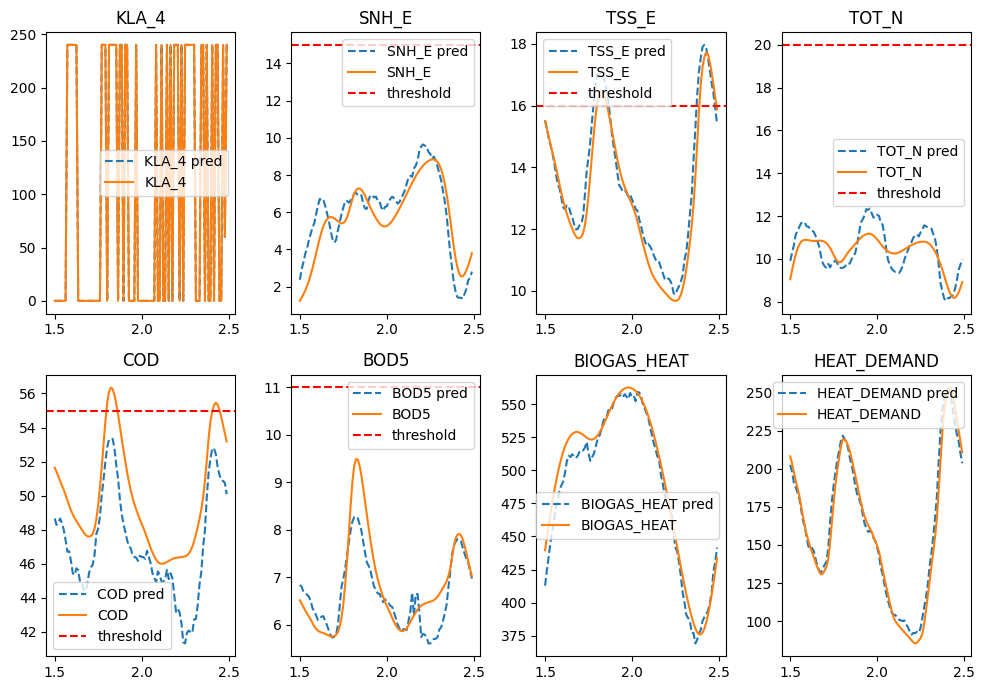

In [145]:
plot_results(last_steps, last_steps+optimization_steps)


### Compare BSM2_OL with random Kla values Vs. BSM2_OL with optimized Kla values 

In [146]:
import numpy as np
import pandas as pd
from bsm2_python import BSM2OL
from tqdm import tqdm


def run_simulation(bsm2, kla_values):
    # iterate up to the minimum length
    sim_length = min(len(bsm2.simtime), len(kla_values))
    print(f"Running simulation for {sim_length} steps")
    
    # Initialize arrays to store effluent quality parameters (SNH, TSS, tot_n, cod, bod5)
    effluent_history = np.zeros((sim_length, 5))  
    
    for idx in tqdm(range(sim_length)):
        kla_4 = kla_values[idx]
        klas = np.array([0, 0, KLA3GAIN * kla_4, kla_4, KLA5GAIN * kla_4])
        bsm2.step(idx, klas)
        
        # Calculate and store effluent quality parameters
        adv_eff = pp.advanced_quantities(bsm2.y_eff, components=('totalN', 'COD', 'BOD5'))
        tot_n, cod, bod5 = adv_eff[0, :]
        effluent = np.array((bsm2.y_eff[SNH], bsm2.y_eff[TSS], tot_n, cod, bod5))
        effluent_history[idx] = effluent
        
    return bsm2.get_final_performance(), effluent_history


def get_standard_kla_values(simtime_length):
    select_klas = np.array([0, 60, 120, 180, 240])
    return np.random.choice(select_klas, simtime_length)

# Set same endtime for both simulations
endtime = 1

# Initialize models
bsm2_standard = BSM2OL(endtime=endtime)
standard_kla_values = get_standard_kla_values(len(bsm2_standard.simtime))
print(f"Standard simulation length: {len(bsm2_standard.simtime)}")
print(f"Standard KLA values length: {len(standard_kla_values)}")

bsm2_optimized = BSM2OL(endtime=endtime)
print(f"Optimized simulation length: {len(bsm2_optimized.simtime)}")
print(f"Optimized KLA values length: {len(gurobi_kla)}")

# Run simulations
oci_standard, effluent_standard = run_simulation(bsm2_standard, standard_kla_values)
oci_optimized, effluent_optimized = run_simulation(bsm2_optimized, gurobi_kla)

# Compare results
print("\nResults Comparison:")

# Corresponding variable names
variable_names = [
    'IQI (kg/d)', 'EQI (kg/d)', 'Total Sludge Production (kg/d)',
        'Total TSS Mass (kg/d)', 'Carbon Mass (kg_COD/d)', 'CH4 Production (kg_CH4/d)',
        'H2 Production (kg_H2/d)', 'CO2 Production (kg_CO2/d)', 'Gas Production (m3/d)',
        'Heat Demand (kWh/d)', 'Mixing Energy (kWh/d)', 'Pumping Energy (kWh/d)',
        'Aeration Energy (kWh/d)', 'OCI'
]

oci_standard_list = list(oci_standard)
oci_optimized_list = list(oci_optimized)
improvement = [round((opt - std) / std * 100, 2) if std != 0 else 0 for std, opt in zip(oci_standard_list, oci_optimized_list)]

df = pd.DataFrame({
	'oci_standard': oci_standard_list,
	'oci_optimized': oci_optimized_list,
	'improvement': improvement
}, index=variable_names)

df

Standard simulation length: 97
Standard KLA values length: 97
Optimized simulation length: 97
Optimized KLA values length: 96
Running simulation for 97 steps


100%|██████████| 97/97 [00:01<00:00, 96.82it/s] 


Running simulation for 96 steps


100%|██████████| 96/96 [00:01<00:00, 94.07it/s] 



Results Comparison:


,oci_standard,oci_optimized,improvement
IQI (kg/d),77117.231371,77117.231371,0.00
EQI (kg/d),5131.746248,6320.372584,23.16
Total Sludge Production (kg/d),4497.284602,4509.051258,0.26
Total TSS Mass (kg/d),4189.417539,4200.967943,0.28
Carbon Mass (kg_COD/d),800.000000,800.000000,0.00
CH4 Production (kg_CH4/d),962.788682,969.529043,0.70
H2 Production (kg_H2/d),0.061979,0.053811,-13.18
CO2 Production (kg_CO2/d),917095.079723,917378.021036,0.03
Gas Production (m3/d),530242.397900,530416.374981,0.03
Heat Demand (kWh/d),4130.108828,4131.265952,0.03


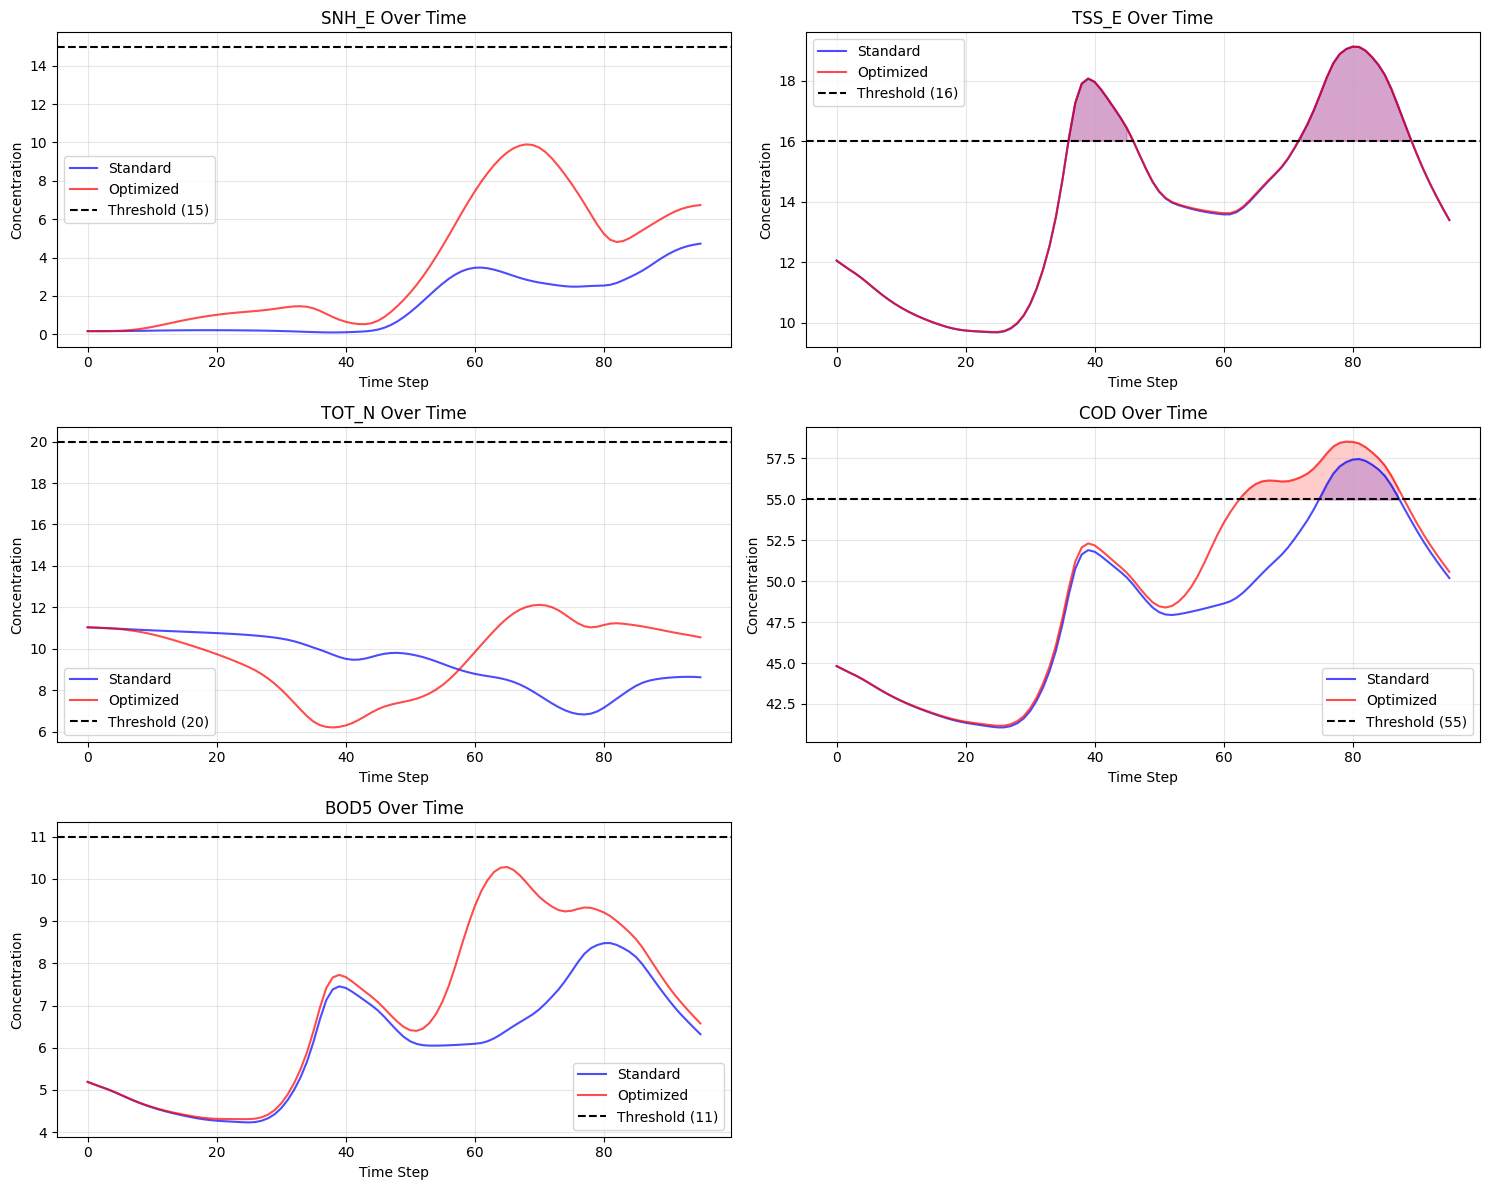

In [147]:


def plot_effluent_parameters(effluent_standard, effluent_optimized, thresholds):
    parameters = ['SNH_E', 'TSS_E', 'TOT_N', 'COD', 'BOD5']
    threshold_values = [thresholds[param] for param in parameters]
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 12))
    axs = axs.ravel()
    
    min_length = min(len(effluent_standard), len(effluent_optimized))
    time_steps = np.arange(min_length)
    
    for i, (param, threshold) in enumerate(zip(parameters, threshold_values)):
        ax = axs[i]
        
        # Plot standard and optimized values
        ax.plot(time_steps, effluent_standard[:min_length, i], 'b-', label='Standard', alpha=0.7)
        ax.plot(time_steps, effluent_optimized[:min_length, i], 'r-', label='Optimized', alpha=0.7)
        
        # Add threshold line
        ax.axhline(y=threshold, color='k', linestyle='--', label=f'Threshold ({threshold})')
        ax.set_title(f'{param} Over Time')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Concentration')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        ax.fill_between(time_steps, 
                       effluent_standard[:min_length, i], 
                       threshold,
                       where=(effluent_standard[:min_length, i] > threshold),
                       color='blue', alpha=0.2)
        ax.fill_between(time_steps, 
                       effluent_optimized[:min_length, i], 
                       threshold,
                       where=(effluent_optimized[:min_length, i] > threshold),
                       color='red', alpha=0.2)
    axs[-1].remove()
    plt.tight_layout()
    plt.show()

thresholds = {
    'SNH_E': 15,
    'TSS_E': 16,
    'TOT_N': 20,
    'COD': 55,
    'BOD5': 11
}

plot_effluent_parameters(effluent_standard, effluent_optimized, thresholds)

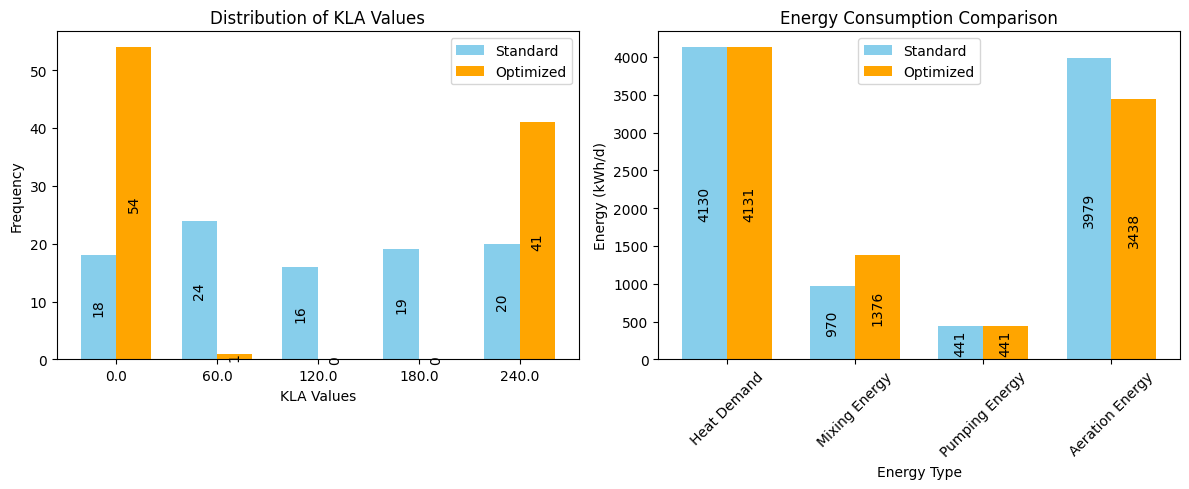

In [148]:
import matplotlib.pyplot as plt
import numpy as np

# KLA Values Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# Count frequency of KLA values
standard_unique, standard_counts = np.unique(standard_kla_values, return_counts=True)
optimized_unique, optimized_counts = np.unique(gurobi_kla, return_counts=True)

# Ensure both arrays have the same shape by including all possible KLA values
all_kla_values = np.union1d(standard_unique, optimized_unique)
standard_counts = np.array([standard_counts[np.where(standard_unique == val)[0][0]] if val in standard_unique else 0 for val in all_kla_values])
optimized_counts = np.array([optimized_counts[np.where(optimized_unique == val)[0][0]] if val in optimized_unique else 0 for val in all_kla_values])

x = np.arange(len(all_kla_values))
width = 0.35
bars1 = plt.bar(x - width/2, standard_counts, width, label='Standard', color='skyblue')
bars2 = plt.bar(x + width/2, optimized_counts, width, label='Optimized', color='orange')
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height/2,
                f'{int(height)}',
                ha='center', va='center',
                rotation=90)

plt.xlabel('KLA Values')
plt.ylabel('Frequency')
plt.title('Distribution of KLA Values')
plt.xticks(x, all_kla_values)
plt.legend()

# Energy Comparison
plt.subplot(1, 2, 2)

energy_metrics = ['Heat Demand', 'Mixing Energy', 'Pumping Energy', 'Aeration Energy']
standard_energies = [oci_standard[9], oci_standard[10], oci_standard[11], oci_standard[12]]
optimized_energies = [oci_optimized[9], oci_optimized[10], oci_optimized[11], oci_optimized[12]]
x = np.arange(len(energy_metrics))

bars3 = plt.bar(x - width/2, standard_energies, width, label='Standard', color='skyblue')
bars4 = plt.bar(x + width/2, optimized_energies, width, label='Optimized', color='orange')

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height/2,
                f'{height:.0f}',
                ha='center', va='center',
                rotation=90)

plt.xlabel('Energy Type')
plt.ylabel('Energy (kWh/d)')
plt.title('Energy Consumption Comparison')
plt.xticks(x, energy_metrics, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()